In [1]:
#Data manipulation
import pandas as pd
import numpy as np

#Plot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#Dataset
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
import tensorflow_datasets as tfds

#Image manipulation
from skimage.transform import resize
from skimage.feature import hog
from skimage import color

#Model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

#Read Image from url
from PIL import Image
import urllib.request

# 1. Import dataset


To train a face detection model, first of all it is necessary a dataset of faces, and a dataset of non-faces. The dataset chosen are the following:

- **LFW** from sklearn as human faces dataset
- **Caltech101** from tensorflow (specially filtered) as non human faces dataset

Since it is necessary, for extracting features, that all images in the dataset have the same size, a standard size of 64X64 was chosen.

In [2]:
# human faces dataset
faces=fetch_lfw_people()

faces=faces.images
faces.shape

(13233, 62, 47)

The dataset contains 13233 images of shape 62X47. For simplicity in training the model, let's consider only the first 5000. Subsequently, also from the non-face dataset only 5000 examples will be considered, thus obtaining a dataset of 10000 examples.

In [3]:
#total number of example for dataset
n_img=5000

#slice the faces dataset
faces=faces[:n_img]

#resize all imagis to 64x64
resized_faces = []
for image in faces:
    resized_image = resize(image, (64, 64), anti_aliasing=True)
    resized_faces.append(resized_image)

faces = np.array(resized_faces)

faces.shape

(5000, 64, 64)

In [4]:
def plot_random_images(dataset, num_rows=2, num_cols=3):
    """
    Plot random images from the dataset.

    Parameters:
    - dataset [np.array]: image dataset
    - num_rows [int]: plot row (default: 2)
    - num_cols [int]: plot column (default: 3)

    Returns:
    - plot of random images
    """
    # Total number of images
    num_images = num_rows * num_cols

    # Select random images
    random_indices = np.random.choice(dataset.shape[0], num_images, replace=False)
    selected_images = dataset[random_indices]

    # plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

    for i, ax in enumerate(axes.flatten()):
        #plot selected images
        ax.imshow(selected_images[i], cmap='gray')
        ax.axis("off")

    plt.tight_layout()
    plt.show()

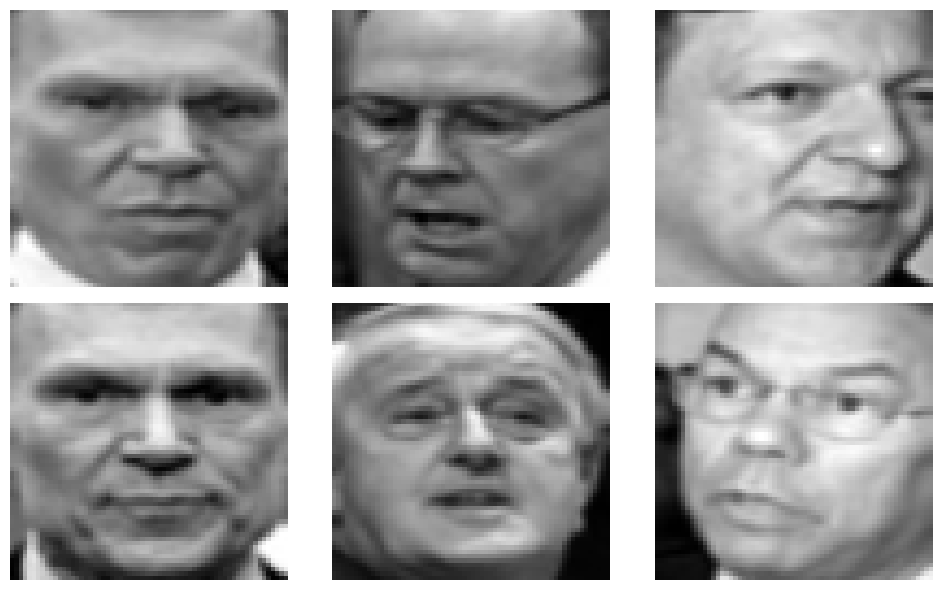

In [5]:
plot_random_images(faces)

Let's import Caltech100 from tensorflow.

In [6]:
# load dataset caltech101
tf_data, tf_info = tfds.load("caltech101", split='test',with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.RZN7UQ_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.RZN7UQ_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [7]:
# list all label
label_names = tf_info.features['label'].names  # Lista di esempio

# convert list into df
df_labels = pd.DataFrame(label_names, columns=["Labels"])

print(df_labels)

                Labels
0            accordion
1            airplanes
2               anchor
3                  ant
4    background_google
..                 ...
97          wheelchair
98            wild_cat
99       windsor_chair
100             wrench
101           yin_yang

[102 rows x 1 columns]


The dataset contains 102 categories. To have a dataset suitable as a negative class, all those that are faces must be excluded.

In [8]:
# Find 'faces' in column 'Labels'
faces_label = df_labels[df_labels["Labels"].str.contains('faces', case=False, na=False)]

print(faces_label)

        Labels
37       faces
38  faces_easy


The two categories **faces** and **faces_easy** must be removed. In addition, the caltech101 dataset contain color image with different size.
In order to be compatible with the next steps, all images will be converted to grayscale and resized to 64x64

In [9]:
#Non faces images
non_faces = []

#Label to exclude
exclude_labels = ['faces','faces_easy']

# Filter images
for image, label in tf_data:
    # label to str
    label_str = tf_info.features['label'].int2str(label.numpy())

    # check for label
    if label_str not in exclude_labels:
        img=image.numpy()
        #img gray scale
        img=color.rgb2gray(img)
        #img resize
        img=resize(img, (64, 64), anti_aliasing=True)
        # add image
        non_faces.append(img)


non_faces = np.array(non_faces)

print(non_faces.shape)

(5274, 64, 64)


In [10]:
#select first n_img
non_faces=non_faces[:n_img]

non_faces.shape

(5000, 64, 64)

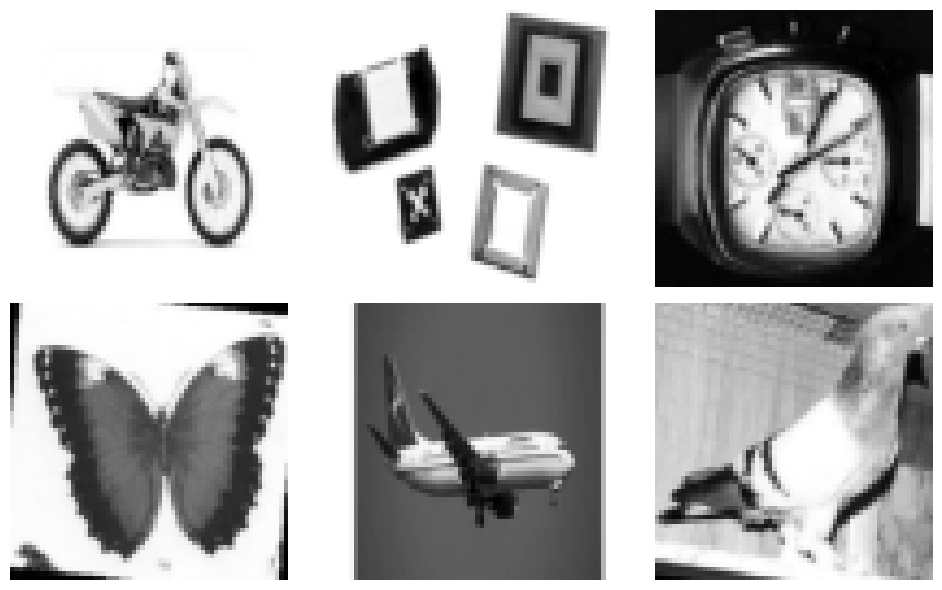

In [11]:
plot_random_images(non_faces)

Once obtained the two datasets, they must be joined. It is also necessary to create an array that contains the class 0 (not faces) and 1 (faces).

In [12]:
#y array, 0=not_faces, 1=faces
y_pos=np.ones(faces.shape[0], dtype=int)
y_neg=np.zeros(non_faces.shape[0], dtype=int)

#concat faces and not faces array
X=np.concatenate((faces, non_faces), axis=0)
y=np.concatenate((y_pos, y_neg), axis=0)

print(X.shape)
print(y.shape)

(10000, 64, 64)
(10000,)


In [13]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(8000, 64, 64)
(2000, 64, 64)


# 2. HOG Feature extraction

The key concepts of the model pipeline are the following:

1. **HOG feature extraction** from the image dataset
2. Use the extracted feature to train a **SVC**
3. Use a **Sliding Window** to scan different region of a new image, applying the model pipeline to all region found

A well explained example can be found at https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html

In [14]:
# HOG features extraction
class HogFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys'):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Extract HOG features for all images
        hog_features = []
        for image in X:
            # Convert to grayscale if necessary
            if image.ndim == 3:
                image = color.rgb2gray(image)

            #Resize image
            image=resize(image, (64, 64), anti_aliasing=True)

            #hog
            features = hog(
                image,
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                block_norm=self.block_norm
            )
            hog_features.append(features)
        return np.array(hog_features)

# 3. Model pipeline

The pipeline will consist of the following steps:

1. HOG Features extraction
2. Standard Scaler
3. PCA
4. SVC

**3.1 PCA Analysis**

Let's extract HOG features from train set to understand the dimensionality.

In [15]:
#train set hog features
hog_features_train=HogFeatureExtractor().fit_transform(X_train)

hog_features_train.shape

(8000, 1764)

For every image has been identified 1764 features.

Performing a PCA analysis it is possible to identify how many features are needed to explain most of the variance.

In [16]:
#Apply Standard scaler to simulate the step of pipeline
hog_features_train=StandardScaler().fit_transform(hog_features_train)

<function matplotlib.pyplot.show(close=None, block=None)>

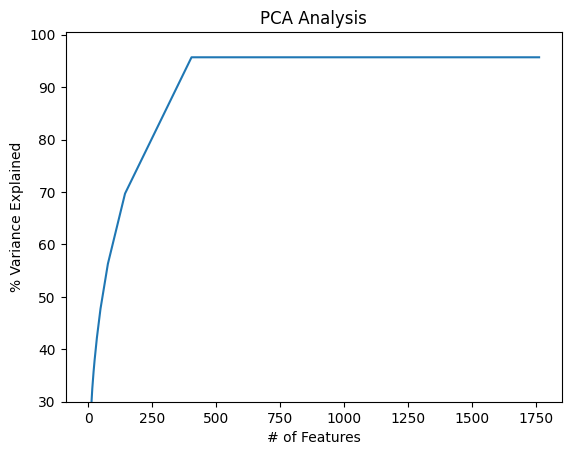

In [17]:
#PCA
pca=PCA(n_components=1764, whiten=True, random_state=0)
pca.fit(hog_features_train)

#Explained variance
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

#Plot
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.show

The graph show that after a certain number of features between 250 and 500 the function becomes constant.

In [18]:
#max explained variance
max_var = np.max(var)

# Find all index where var is max
index_max = np.where(var == max_var)[0]

print("Max variance:", round(max_var,2))
print("Minimum number of features for max variance:", index_max[0])

Max variance: 95.7
Minimum number of features for max variance: 404


With 404 features, 95.7% of the variance can be explained. A further increase in features does not lead to an increase in explained variance.

**3.2 Pipeline**

In [19]:
# Pipeline
model = Pipeline([
    ('hog', HogFeatureExtractor()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=404, whiten=True, random_state=0)),
    ('svm', SVC(kernel='rbf', probability=True))
])

In [20]:
# Model fit
model.fit(X_train, y_train)

Pipeline(steps=[('hog', HogFeatureExtractor()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=404, random_state=0, whiten=True)),
                ('svm', SVC(probability=True))])

In [21]:
#prediction
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

In [22]:
#Testing model
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3988
           1       1.00      1.00      1.00      4012

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1012
           1       1.00      0.98      0.99       988

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



The model performs extremely well on both the training and test sets.

# 4. Sliding window

The model as it is designed can classify an image as a face or a non-face. To detect the presence of one or more faces and related bounding boxes, it is necessary to combine the model with a sliding window.

Since the model was trained on images of 64X64 size, and since the dimensions of the images that we are going to analyze are not known, nor the dimensions occupied by the face, in order to make the model more robust, the sliding window will be combined with the pyramid method.

A well explained example of sliding window combined with image pyramid can be found at https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

In this case the concept of image pyramid has been re-adapted. Rather than scaling the image size, the size of the sliding window is progressively increased. This was done because the test performed showed better results using this method.

In [23]:
def sliding_window_with_scaled_window_sizes(pipeline, image, initial_window_size=(64, 64), step_size=16, threshold=0.5):
    """
    Applies a sliding window to an image, scaling the window size at each iteration until it exceeds the image size.

    Parameters:
    - pipeline: trained pipeline
    - image [np.array]: input image
    - initial_window_size [tuple]: (height, width), initial size of the window
    - step_size [int]: window advance step in pixels
    - threshold [float]: threshold for classification

    Returns:
    - detected_windows [tuple list]: [(x1, y1, x2, y2, probability)], coordinates of the windows belonging to class 1 and class 1 probability
    """
    detected_windows = []
    window_size = initial_window_size

    while window_size[0] <= image.shape[0] and window_size[1] <= image.shape[1]:
        print(f"Testing window size: {window_size}")

        # Sliding Window
        for y in range(0, image.shape[0] - window_size[0] + 1, step_size):
            for x in range(0, image.shape[1] - window_size[1] + 1, step_size):
                # Extract window
                window = image[y:y + window_size[0], x:x + window_size[1]]

                # check window shape
                if window.shape != window_size:
                    continue

                # Window is 2 dim, Pipeline need 3 dim array
                window = window[np.newaxis, ...]  # Add new dimension

                # Predict class and probability
                prediction = pipeline.predict(window)
                probabilities = pipeline.predict_proba(window)

                # check if window has been classified has class 1
                if prediction[0] == 1:
                    prob_class_1 = probabilities[0][1]  # Store Class 1 probability

                    if prob_class_1 < threshold: #ignore bounding box found if probability < threshold
                        continue

                    # Store windows coordinates and class 1 probability
                    detected_windows.append((x, y, x + window_size[1], y + window_size[0], prob_class_1))

        # Enlarge the window by multiplying the dimensions by a factor of 2
        window_size = (window_size[0] * 2, window_size[1] * 2)

    return detected_windows

# 5. Non-Max Suppression (NMS)

As the sliding window progresses, different regions of the image are tested. Depending on the step size parameter chosen, there will be windows that share portions of the image.
This can lead to overlapping bounding boxes. To limit this phenomenon, the Non max suppression procedure can be applied to the bounding boxes. This method removes bounding boxes that have intersection areas greater than a threshold value.

In [24]:
def non_max_suppression(bounding_boxes, iou_threshold=0.5):
    """
    Applies Non-Max Suppression (NMS) on a list of bounding boxes.

    Parameters:
    - bounding_boxes [list of tuple]: (x1, y1, x2, y2, probability)
        - (x1, y1): Coordinates of the lower right point.
        - (x2, y2): Coordinates of the top left point.
        - probability: Probability that the box belongs to the positive class.
    - iou_threshold [float]: Threshold for IoU overlap ratio. Boxes with IoU > threshold will be deleted.

    Returns:
    - filtered_boxes [list of tuples]: Bounding boxes remaining after applying the NMS, sorted by probability.
    """
    if not bounding_boxes:
        return []

    # Sort bounding box by probability
    bounding_boxes = sorted(bounding_boxes, key=lambda box: box[4], reverse=True)
    filtered_boxes = []

    while bounding_boxes:
        # Select bounding box with highest probability
        best_box = bounding_boxes.pop(0)
        filtered_boxes.append(best_box)

        # Keep bounding box with IoU <= threshold
        bounding_boxes = [
            box for box in bounding_boxes
            if compute_iou(best_box, box) <= iou_threshold
        ]

    return filtered_boxes

def compute_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) beetwen 2 bounding box.

    Parameters:
    - box1, box2 [tuple]: bounding box in the shape (x1, y1, x2, y2, probability)

    Returns:
    - iou [float]: Intersection over Union (IoU) beetwen 2 bounding box.
    """
    # Evaluate intersection
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Evaluate intersection area
    intersection_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Evaluate boxes area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])  # box1 area
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])  # box2 area

    # Evaluate union area
    union_area = box1_area + box2_area - intersection_area

    # Check division by 0
    if union_area == 0:
        return 0

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

# 6. Test

In [25]:
def plot_bb(img, model, window_size=(64, 64), step_size=16, sliding_threshold=0.5, nms_threshold=0.5):
  """
  Plots an image with bounding boxes predicted by a model using a sliding window approach and Non-Max Suppression.

  Parameters:
    - img [np.array]: Input image. Can be a grayscale or RGB image.
    - model: Trained model for face detection.
    - window_size [tuple] (width, height), optional. Size of sliding window
    - step_size [int]: optional. Step size for moving the sliding window
    - sliding_threshold [float]: optional. Probability threshold for keep bounding boxes during the sliding window phase
    - nms_threshold [float]: optional. Intersection over Union (IoU) threshold for Non-Max Suppression

    Returns:
      The function displays the image with bounding boxes overlaid.
  """

  # Convert gray scale if necessary
  if img.ndim==3:
    original_img=img.copy() # Save the original image
    img=color.rgb2gray(img)

  # Apply sliding window
  bb=sliding_window_with_scaled_window_sizes(model, img,
                                             initial_window_size=window_size, step_size=step_size, threshold=sliding_threshold)

  # Apply NMS
  bb=non_max_suppression(bb, iou_threshold=nms_threshold)

  # Plot
  fig, ax = plt.subplots(1)
  if original_img.ndim==3:
    ax.imshow(original_img)
  else:
    ax.imshow(img, cmap='gray')

  # Add all bounding box found
  for (x1, y1, x2, y2, prob) in bb:
    rect=Rectangle((x1, y1), x2-x1, y2-y1, fill=False, facecolor=None, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

The **plot_bb** function requires the image and the trained model as mandatory input.
There are also several optional parameters:

- **window_size** and **step_size** :
These two parameters affect the initial size and advancement of the sliding window. These parameters affect the predictions of the model and total time required.

- **sliding_threshold** and **nms_threshold** :
These two parameters influence how many bounding boxes will be discarded from all those returned by the model.


Since the model was trained on 64x64 size images and since the size of the new image and the area occupied by the faces are not known, it follows that depending on how the optional parameters are set, a better or worse result will be obtained.

Let's test the model with some images.

In [26]:
def img_from_url(url):
  """
  Import image from url

  Parameters:
    - url [str]: url of the image

  Returns:
    - img [np.array]: image
  """

  with urllib.request.urlopen(url) as response:
    img = Image.open(response)

  return np.array(img)

For the test phase the optional parameters will be initially set as follows:

- window_size = 128x128 to reduce calculation times as images nowadays have high resolutions
- step_size = 16
- nms_threshold=0.1
- sliding_threshold= 0.5 (default)

**6.0 Olivetti faces**

In [27]:
#import dataset
data_olivetti=fetch_olivetti_faces()
X_olivetti=data_olivetti.images

print(X_olivetti.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


In [28]:
#prediction
y_pred_olivetti=model.predict(X_olivetti)

In [29]:
#total faces detected
faces_detected=np.sum(y_pred_olivetti)

print(f'Total faces detected: {faces_detected}')
print(f'Accuracy: {faces_detected/X_olivetti.shape[0]*100}%')

Total faces detected: 390
Accuracy: 97.5%


With the olivatti faces dataset the model was able to identify 390 faces out of 400 (97.5% of accuracy).

**6.1 Image #1**

Testing window size: (128, 128)
Testing window size: (256, 256)


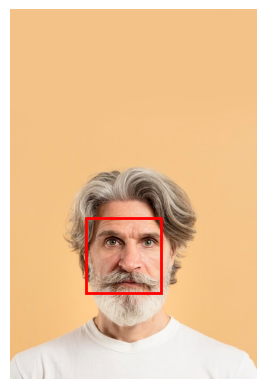

In [30]:
url1="https://img.freepik.com/foto-gratuito/ritratto-di-uomo-anziano-con-copia-spazio_23-2148621124.jpg?ga=GA1.1.592445683.1742812056&semt=ais_keywords_boost"
img1=img_from_url(url1)

plot_bb(img1, model, nms_threshold=0.1, sliding_threshold=0.5, window_size=(128,128), step_size=16)

The model performs very well with image #1, identifying only one bounding box.

**6.2 Image #2**

Testing window size: (128, 128)
Testing window size: (256, 256)
Testing window size: (512, 512)


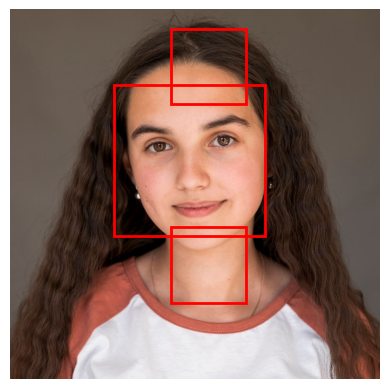

In [31]:
url2="https://img.freepik.com/foto-gratuito/ragazza-con-i-capelli-lunghi-essendo-felice_23-2148244714.jpg?ga=GA1.1.592445683.1742812056&semt=ais_keywords_boost"
img2=img_from_url(url2)

plot_bb(img2, model, nms_threshold=0.1, sliding_threshold=0.5, window_size=(128,128), step_size=16)

In test number 2, the model is able to correctly identify the face. However, it identifies more than one bounding box. Let's try to modify the nms_threshold parameter.

Testing window size: (128, 128)
Testing window size: (256, 256)
Testing window size: (512, 512)


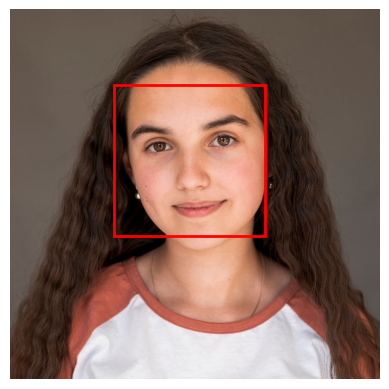

In [32]:
plot_bb(img2, model, nms_threshold=0.01, sliding_threshold=0.5, window_size=(128,128), step_size=16)

With an extremely low threshold value, it is possible to exclude superfluous bounding boxes.

**6.3 Image #3**

Testing window size: (128, 128)
Testing window size: (256, 256)


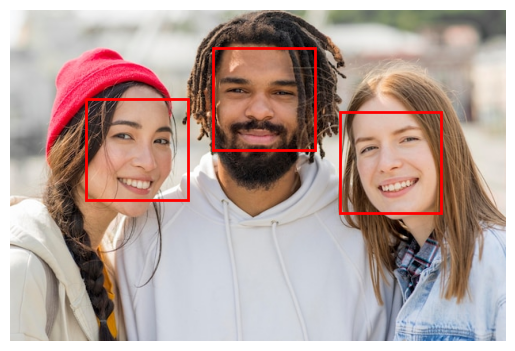

In [33]:
url3="https://img.freepik.com/foto-gratuito/amici-di-smiley-vista-frontale_23-2148576843.jpg?ga=GA1.1.592445683.1742812056&semt=ais_keywords_boost"
img3=img_from_url(url3)

plot_bb(img3, model, nms_threshold=0.1, sliding_threshold=0.5, window_size=(128,128), step_size=16)

In test number 3 the model performs very well identifying all faces, without identifying unnecessary bounding boxes.

**6.4 Image #4**

Testing window size: (128, 128)
Testing window size: (256, 256)


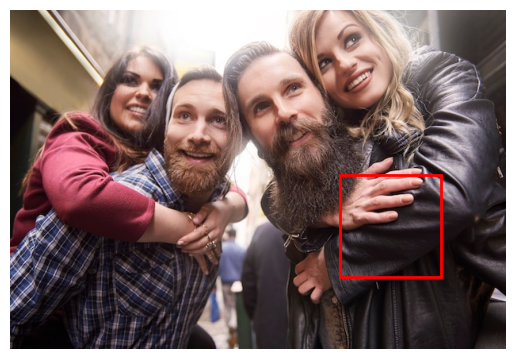

In [34]:
url4="https://img.freepik.com/foto-gratuito/pronto-a-conquistare-la-citta_329181-10598.jpg?ga=GA1.1.592445683.1742812056&semt=ais_keywords_boost"
img4=img_from_url(url4)

plot_bb(img4, model, nms_threshold=0.1, sliding_threshold=0.5, window_size=(128,128), step_size=16)

In this case the model identify only one bounding box that is not associated with a face.

Let's try to modify parameters to see if better results are achieved.

Testing window size: (64, 64)
Testing window size: (128, 128)
Testing window size: (256, 256)


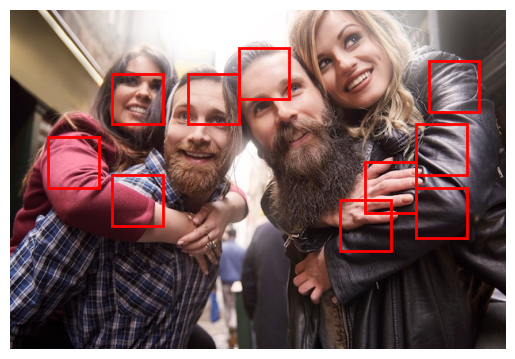

In [35]:
plot_bb(img4, model, nms_threshold=0.1, sliding_threshold=0.5, window_size=(64,64), step_size=16)

By reducing the size of the sliding window, a greater number of bounding boxes were identified. In this case, 3 out of 4 faces were identified. However, there are a large number of bounding boxes not associated with any face.

From the image it can be seen that there are only 2 overlapping bounding boxes. So let's try to change the sliding_threshold parameter to see if it is possible to do a skimming.

Testing window size: (64, 64)
Testing window size: (128, 128)
Testing window size: (256, 256)


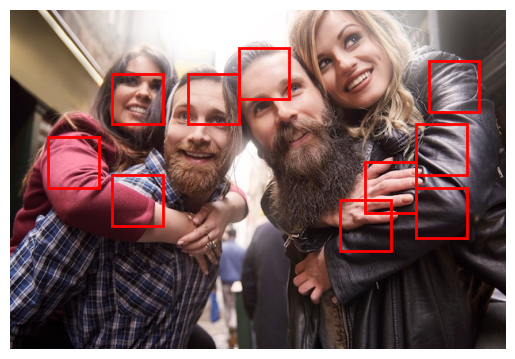

In [36]:
plot_bb(img4, model, nms_threshold=0.1, sliding_threshold=0.90, window_size=(64,64), step_size=16)

With a sliding_threshold value of 0.9 no bounding boxes has been removed.

Testing window size: (64, 64)
Testing window size: (128, 128)
Testing window size: (256, 256)


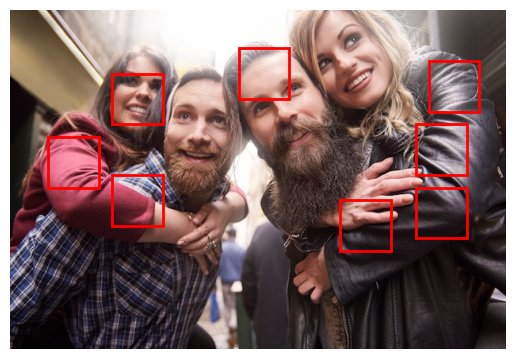

In [37]:
plot_bb(img4, model, nms_threshold=0.1, sliding_threshold=0.95, window_size=(64,64), step_size=16)

Further increasing the threshold removes one of the bounding boxes associated with a face.

# 7. Conclusion

The resulting model shows very high performance in classifying standard 64x64 size images as faces or non-faces.

From the tests carried out, it is observed that the quality of the results of model combined with sliding window depends on the parameters of the sliding window and the thresholds. Obviously, it is not possible to change the parameters from time to time to improve the results. The model should be extensively tested to find the optimal combination of parameters.

As a final step, the model should be trained on a larger dataset, also using hard negative techniques to improve its performance.